In [77]:
import numpy as np
import matplotlib.pyplot as plt

import aero_model
import dynamic
# Modèle d'avion
aircraft = aero_model.Airbus_A319_100()

In [78]:
aircraft.set_options(stall=True, buffeting=False, wave_drag=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dynamic

def optimize_for_range_existing_trim_mass_cg(aero_m, altp, mass, cg_pct_mac):
    """
    Optimisation de Fn/V en utilisant graceful_trim avec masse et centrage variables
    """
    # Mise à jour des paramètres masse et centrage
    aero_m.m = mass
    rxg = cg_pct_mac / 100.0  # conversion %MAC -> fraction MAC
    aero_m.set_balance(rxg)

    speeds = np.linspace(130, 250, 50)  # plage de vitesses adaptée à l'A319
    fn_over_v = []
    solutions = []

    previous_guess = [0.05, 0.0, 0.5]  # [aoa, dtrim, dthr]

    for tas in speeds:
        aoa, dtrim, dthr = dynamic.graceful_trim(aero_m, altp, tas)

        if not np.isnan(aoa):
            previous_guess = [aoa, dtrim, dthr]

            res = dynamic.get_trim_level_flight(aero_m, altp, tas, use_saturations=True)

            fu = res["fu"][0]  # daN
            fn = fu * 10       # N

            fn_over_v.append(fn / tas)
            solutions.append(res)

        else:
            fn_over_v.append(np.nan)
            solutions.append(None)

    fn_over_v = np.array(fn_over_v)

    if np.all(np.isnan(fn_over_v)):
        raise Exception("Aucune convergence obtenue sur la plage de vitesses testée.")
        
    idx_opt = np.nanargmin(fn_over_v)
    sol_opt = solutions[idx_opt]

    # Affichage
    plt.figure(figsize=(10, 6))
    plt.plot(speeds, fn_over_v, label=r"$F_n/V$")
    plt.scatter(speeds[idx_opt], fn_over_v[idx_opt], color='red', label="Optimal")
    plt.xlabel("Vitesse vraie TAS (m/s)")
    plt.ylabel(r"$F_n/V$ (N·s/m)")
    plt.title(f"Optimisation (m={mass/1000:.1f} t, CG={cg_pct_mac:.1f} %MAC)")
    plt.grid()
    plt.legend()
    plt.show()

    return sol_opt


In [80]:
aircraft = aero_model.Airbus_A319_100()
altp = 5000      # altitude en m
mass = 65000     # masse en kg
cg = 27.5        # centrage en %MAC

sol_opt = optimize_for_range_existing_trim_mass_cg(aircraft, altp, mass, cg)
print(sol_opt)


Exception: Throttle saturation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def optimize_for_range_existing_trim_mass_cg(aero_m, altp, mass, cg_pct_mac):
    """
    Optimisation de Fn/V en utilisant graceful_trim avec masse et centrage variables
    Retourne : (min(Fn/V), solution complète, vitesse optimale)
    """
    # Mise à jour des paramètres masse et centrage
    aero_m.m = mass
    rxg = cg_pct_mac / 100.0  # conversion %MAC -> fraction MAC
    aero_m.set_balance(rxg)

    speeds = np.linspace(130, 250, 50)  # plage de vitesses adaptée à l'A319
    fn_over_v = []
    solutions = []

    for tas in speeds:
        aoa, dtrim, dthr = dynamic.graceful_trim(aero_m, altp, tas)

        if not np.isnan(aoa):
            previous_guess = [aoa, dtrim, dthr]

            res = dynamic.get_trim_level_flight(aero_m, altp, tas, use_saturations=False)

            fu = res["fu"][0]  # daN
            fn = fu * 10       # N

            fn_over_v.append(fn / tas)
            solutions.append((tas, res))  # on stocke TAS avec la solution complète

        else:
            fn_over_v.append(np.nan)
            solutions.append((tas, None))

    fn_over_v = np.array(fn_over_v)

    if np.all(np.isnan(fn_over_v)):
        raise Exception("Aucune convergence obtenue sur la plage de vitesses testée.")
        
    idx_opt = np.nanargmin(fn_over_v)
    min_fn_over_v = fn_over_v[idx_opt]
    tas_opt, sol_opt = solutions[idx_opt]

    return min_fn_over_v, sol_opt, tas_opt


In [ ]:
aircraft = aero_model.Airbus_A319_100()
altp = 5000      # altitude en m
mass = 65000     # masse en kg
cg = 27.5        # centrage en %MAC

sol_opt = optimize_for_range_existing_trim_mass_cg(aircraft, altp, mass, cg)
print(sol_opt)


(3654.326518717835, {'dthr': [0.545010787844615, 'no_dim'], 'aoa': [0.013359458702040108, 'deg'], 'dtrim': [-0.08301760379681121, 'deg'], 'dm': [0.0, 'deg'], 'cz': [0.6663686907993984, 'no_dim'], 'cx': [0.055332568558350635, 'no_dim', 4], 'cm': [5.551115123125783e-17, 'no_dim', 4], 'fu': [52875.86738308051, 'daN'], 'lod': [12.042974113820204, 'no_dim']}, 144.69387755102042)


In [ ]:
from scipy.optimize import fsolve
import atmosphere

import math

def altitude_from_density(rho):
    # Constantes ISA
    rho0 = 1.225       # kg/m3, densité au niveau de la mer
    T0 = 288.15        # K, température au niveau de la mer
    L = 0.0065         # K/m, gradient thermique
    g = 9.80665        # m/s2
    M = 0.0289644      # kg/mol
    R = 8.3144598      # J/(mol·K)

    # Calcul de l'exposant
    exponent = (g * M) / (R * L) - 1

    # Sécurité pour éviter des racines de négatifs
    if rho <= 0 or rho > rho0:
        raise ValueError("La densité doit être comprise entre 0 et {:.3f} kg/m3".format(rho0))

    # Calcul de l'altitude
    ratio = (rho / rho0) ** (1 / exponent)
    h = (T0 / L) * (1 - ratio)

    return h

def ceiling_altitude(aero_m, mass, Cz, tas):
    density = (mass * 9.81) / (tas**2 * aero_m.w.s * Cz)
    print(mass, Cz, tas, aero_m.w.s)
    print(density)
    return altitude_from_density(density)

In [ ]:
atm =atmosphere.AtmosphereISA()

def atmosphere_properties(atm, altitude, tas):
    """
    Calcule sigma, Mach et densité à partir de l'altitude (m) et TAS (m/s).
    """
    pamb, tamb = atm.atmosphere(altitude)
    rho = atm.air_density(pamb, tamb)
    sigma = rho / atm.rho0
    vsnd = atm.sound_speed(tamb)
    mach = tas / vsnd
    
    return sigma, mach, rho

import numpy as np
import scipy.optimize

def ceiling_altitude(aero_model, atm, tas, dthr, cx, h_min=5000, h_max=20000):
    """
    Trouve l'altitude où poussée = traînée pour une masse donnée.
    - aero_model : ton modèle d'avion (ex: aircraft)
    - atm : ton modèle AtmosphereISA
    - mass : masse actuelle de l'avion (kg)
    - tas_law : fonction qui donne TAS en fonction de l'altitude (m)
    - h_min / h_max : bornes de recherche d'altitude (m)
    """
    
    g = atm.g
    
    def delta_thrust(h):
        pamb, tamb = atm.atmosphere(h)
        rho = atm.air_density(pamb, tamb)
        vsnd = atm.sound_speed(tamb)
        mach = tas / vsnd
        sigma = rho / atm.rho0
        
        q = 0.5 * rho * tas**2
        drag = q * aero_model.w.s * cx
        thrust = aero_model.thrust(sigma, mach, dthr)  # Plein gaz
        
        return thrust - drag

    # Recherche de la racine
    h_opt = scipy.optimize.brentq(delta_thrust, h_min, h_max)
    return h_opt


250.0 1.5747221790055574 0.10642360767474958
19801.25799436419
250.0 1.7106202330601206 0.11526360225358992
19753.9672481596
250.0 1.8556132339590885 0.12462267252315987
19701.801758081805
250.0 2.009746390019545 0.1344899583939366
19644.81710028941
250.0 2.173068563080162 0.14485404306633953
19583.071700717617
250.0 2.345632050577997 0.1557029833454384
19516.62675775449
250.0 2.527492357290714 0.16702434063838853
19445.546145123557
250.0 2.718707958386038 0.1788052127574049
19369.89631687833
250.0 2.9193400539366907 0.19103226637806553
19289.746212209448
250.0 3.129452315451544 0.20369177000845073
19205.16715718705


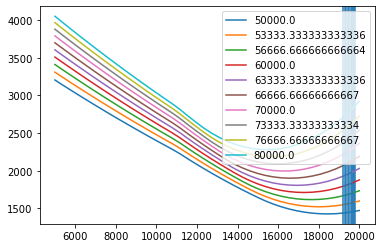

In [ ]:
masses = np.linspace(50000, 80000, 10)
atm =atmosphere.AtmosphereISA()
altps = np.linspace(5000, 20000, 40)
plt.Figure()
for mass in masses :
    a = []
    for altp in altps :
        sol_opt,dic,tas = optimize_for_range_existing_trim_mass_cg(aircraft, altp, mass, cg)
        a.append(sol_opt)
    alti_max = ceiling_altitude(aircraft,atm, tas, dic["dthr"][0], dic["cx"][0])
    print(tas, dic["dthr"][0], dic["cx"][0])
    print(alti_max)
    plt.plot(altps, a, label = f"{mass}")
    plt.axvline(x=alti_max)
plt.legend()
plt.show()